# Monitoring of model
 Evaluate model on data and obtain metrics of performance
 
0. Load libraries
1. Load model and data 
2. Run model on train data to get different thresholds
3. Apply model on chosen dataset
4. Analyse different thresholds
5. ROC curve and FP
6. Monthly overall alert analysis
7. Monthly indicators
8. Daily analysis
9. Missing frauds

## Load libraries

In [1]:
#pip install tabgan==1.3.3

In [2]:
#!pip install lightgbm

In [3]:
#pip install scikit-plot

In [4]:
#%pip install scipy==1.11.4

In [5]:
#pip install --upgrade pandas "dask[complete]"

In [6]:
## Required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data use to train

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [78]:
import os
import joblib
# load model
modelo = joblib.load("ModeloBite.pkl") 
variables = open('./ModeloBite.txt','r')

In [79]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

In [80]:
# Load variable names
variables = open('./ModeloBite.txt','r')
var_input = variables.read()

In [81]:
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud',
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    'receiver_transaction_count','01_sender_sending_days',
    'branch_working_days', '01_net_amount_receiver', 
    'sender_minutes_since_last_transaction_2days', 
    'sender_days_to_last_transaction_365', 
    'sender_days_to_last_transaction_7m', '01_hour_receiver']

In [82]:
# Loas data
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Join datasets loaded
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

## Run model on train data to get different thresholds

In [ ]:
# Predict using laoded model 
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = modelo.predict_proba(testeo[var_input])

# Extract puntuations (probabilites) for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Create a copy ot the labels for further analysis
Y_c = Y_target.copy()

# Set prediction and puntuationsof model for positive labels
Y_c['preds_rf'] = testeo_data_pred_rf
Y_c['score_rf'] = score_rf

# Divide into tiles and compute cature al 0.02% for train/validation dataset
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

In [83]:
#Get diferent threshold
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [86]:
Y_c['pred_corte'] = Y_c['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,16708132,16141
1,12,583


## Apply model on chosen dataset

In [87]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

In [88]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

In [89]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [90]:
# target distribution
testeo['target'].value_counts(dropna=False)

target
False    32966471
True          818
Name: count, dtype: int64

In [93]:
# Predict test using trained model
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = modelo.predict_proba(testeo[var_input])

# Extract puntuations (probabilites) for positive class
# Assumes that second column has probabilites for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

In [94]:
# Create a copy DataFrame 'Y_TESTEO' to preserve original data and save prediction and score
Y_c = Y_target.copy()

Y_c['preds_rf'] = testeo_data_pred_rf
Y_c['score_rf'] = score_rf

In [96]:
# confusion matrix for chosen threshold
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,32637833,328638
1,39,779


## Analyse different thresholds

In [102]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [103]:
# Total Fp in top 0.1%
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,3583,78
2,3800,38
3,6316,23
4,2095,61
5,2121,45
6,2180,66
7,2130,30
8,2205,37
9,2469,28


In [104]:
pd.crosstab(tes_corte_01['date_receiver'].dt.year, Y_c_corte_01['targetF'])

targetF,False,True
date_receiver,,
2023,26362,418
2024,8061,23


In [105]:
# Total Fp in top 0.2%
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,7560,80
2,7604,39
3,11146,25
4,4185,61
5,4232,45
6,4296,67
7,4342,30
8,4464,37
9,4806,31


In [106]:
# Total Fp in top 0.3%
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,11486,82
2,11510,39
3,15654,25
4,6251,61
5,6337,45
6,6468,67
7,6580,30
8,6637,37
9,7174,33


In [107]:
# Total Fp in top 0.4%
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,15287,83
2,15395,39
3,20198,27
4,8425,61
5,8421,45
6,8643,67
7,8770,30
8,8859,37
9,9511,34


In [108]:
pd.crosstab(tes_corte_04['date_receiver'].dt.year, Y_c_corte_04['targetF'])

targetF,False,True
date_receiver,,
2023,105570,445
2024,27457,31


## ROC curve and FP

In [109]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [110]:
# Gain curve and LIFT for data
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# ROC curve for dataset
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# KS statistic for data
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Presicion and recall for dataset
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.926647054582656
ROC FRAUD TESTEO:
0.9711769412269335


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9530119125282507
Precision FRAUD TESTEO:
0.0023647838453996
Recall FRAUD TESTEO:
0.9523227383863081


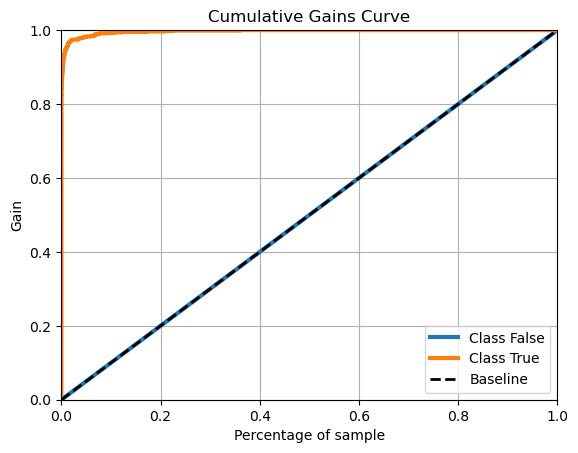

In [111]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


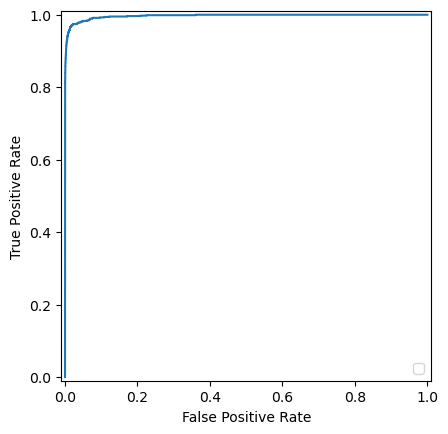

In [112]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

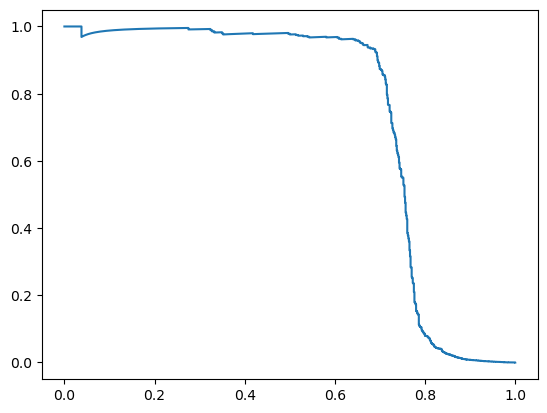

In [113]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [114]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

0.8002735978112175

## Monthly overall alert analysis

In [115]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,3732738,146
2,3887100,72
3,4381826,61
4,2116204,87
5,2289892,69
6,2193663,101
7,2314224,50
8,2296945,68
9,2420668,75


In [116]:
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['target'])

target,False,True
mes,,
1,37929,140
2,38426,68
3,46385,53
4,20965,86
5,21484,69
6,22073,99
7,22060,50
8,21910,68
9,23892,66


In [117]:
# Alerts by month and decile
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [118]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,38084,38037,37562,37012,37111,37085,36842,36932,37097,37385,37120,37171,37000,37102,36958,37100,37092,37050,37125,37049,37128,37328,37364,37141,37191,37560,37314,37154,37101,37066,37170,36942,37499,37374,37491,37520,37531,37735,37491,37579,37584,37572,37483,37039,37043,37508,37411,37411,37583,37400,37305,37618,37645,37609,37287,37456,37927,37685,37467,37602,37293,37771,37536,37508,37880,37158,37630,37433,37721,37388,37696,37606,37438,37432,37310,37289,37267,37642,37354,37306,37139,37342,37148,37324,36982,37550,37057,36991,37258,37129,37112,37031,36848,36846,37103,36959,36789,37046,37347,37997
2,38520,38717,38945,38910,38717,38852,39180,38480,38892,38943,39097,39043,38933,39237,39063,39155,38743,39361,39216,39196,39537,38922,39397,39670,39173,39366,39437,39343,39289,39324,39422,39134,39129,39139,39425,39393,39022,38934,39240,39057,39064,39134,38884,38947,39104,38990,39462,39108,38670,38860,39067,38810,38611,39380,39056,39155,38655,38728,38669,38909,38736,38703,38863,38778,38251,38635,38739,38457,38457,38528,38424,38627,38787,38507,38617,38306,38691,38768,38465,38617,38678,38354,38649,38512,38394,38404,38498,38851,38478,38786,38470,38496,38281,38624,38459,38818,38553,38670,38504,38921
3,46486,43948,44013,44234,44218,44235,44061,44340,43898,43861,44189,44217,44124,44203,44033,44412,44460,44331,44148,44470,44222,44183,44220,44504,44229,44277,44388,44365,44319,44220,44222,43945,44046,44195,44074,44245,44249,44053,44299,44202,44036,43889,44443,44268,44040,43824,43952,44092,44003,44174,43932,44449,43865,43822,43327,43868,43797,43593,43966,43547,43912,43585,43838,43707,43479,43810,43730,43680,43410,43351,43236,43152,43489,43336,43410,43585,43045,43255,43116,43148,43502,43165,43281,43260,43228,43299,43668,43446,43402,43056,43019,43373,43441,43299,43242,42892,42747,42947,42496,42625
4,21067,20932,20528,20910,21067,20868,20677,20670,20760,20699,20852,20591,20719,20749,20516,20621,20720,20672,20771,20638,20518,20687,20618,20575,20768,20857,20702,20787,20511,20885,20574,20848,20604,20704,20677,20529,20585,20804,20875,20634,20684,20806,20711,20955,20698,20758,20856,20797,20691,20904,21120,21061,20895,20834,21016,20772,21094,20824,21003,20967,20970,20725,20827,21038,21356,21175,21091,21522,21205,21476,21353,21503,21221,21367,21547,21557,21349,21791,21672,21488,21460,21720,21608,22042,21848,21928,22238,21996,22167,22185,22259,22312,22527,22466,22349,22453,22494,22420,22839,22532
5,21569,22843,23121,23173,23249,23405,23387,23233,23425,23328,23067,23441,23191,23229,23293,22847,23259,22994,23185,23278,23076,23100,22879,23292,22842,22766,22954,22709,22937,22911,23120,23054,22638,22988,23161,22764,22964,23186,22853,22764,22511,22608,22844,22954,22934,22445,22780,22488,22666,22781,22707,22750,22804,22796,22718,22748,22515,23051,22827,22810,22901,22925,22744,22513,22712,22707,22888,22930,22894,23011,22853,22719,23008,22717,22928,22840,22896,22843,22911,22827,22719,22907,22854,22720,22899,22652,22823,23094,22798,23035,23120,22871,22910,22846,22876,23083,22823,22845,22876,22231
6,22185,23231,23484,23648,23549,23160,23574,23528,23253,23307,23254,22794,22947,22923,22768,22953,22833,22714,22821,22650,22554,22725,22529,22532,22454,22235,22323,22313,22373,22259,22337,22046,22130,22464,22362,21811,22037,22251,21729,22197,22009,21981,21645,21906,22019,22114,21655,22104,21806,21936,21893,21711,21646,21843,21450,21882,21969,21565,21710,21729,21739,21717,21436,21440,21780,21826,21182,21459,21543,21540,21483,21373,21375,21427,21264,21405,21711,21447,21221,21535,21311,21440,21356,21293,21469,21173,21202,21100,21121,20859,21234,20869,20938,20828,21052,20801,207

# Monthly indicators

In [121]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        if not subset_mes.empty:
            precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_01'])
            recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_01'])
            summary_metrics.loc[i,'month'] = m
            summary_metrics.loc[i,'year'] = y
            summary_metrics.loc[i,'precision'] = precision
            summary_metrics.loc[i,'recall'] = recall
            summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_01'].sum()
            summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
            summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_01']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
            #print ('Year:', y, 'Month:',m)
            #print ('Precision:', precision, 'Recall:',recall)
            i = i+1
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.0360884750,0.9687500000,1718,118,64,62
0,2,2023,0.0179514256,1.0000000000,1894,58,34,34
5,3,2023,0.0093370682,0.9090909091,2142,44,22,20
1,4,2023,0.0282931354,1.0000000000,2156,87,61,61
2,5,2023,0.0207756233,1.0000000000,2166,69,45,45
3,6,2023,0.0293855744,0.9428571429,2246,101,70,66
4,7,2023,0.0138888889,1.0000000000,2160,50,30,30
7,8,2023,0.0165031222,1.0000000000,2242,68,37,37
8,9,2023,0.0112134561,0.6363636364,2497,75,44,28
9,10,2023,0.0076274589,0.5937500000,2491,46,32,19


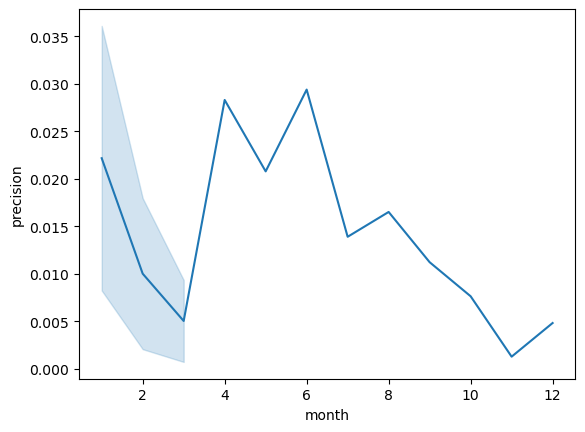

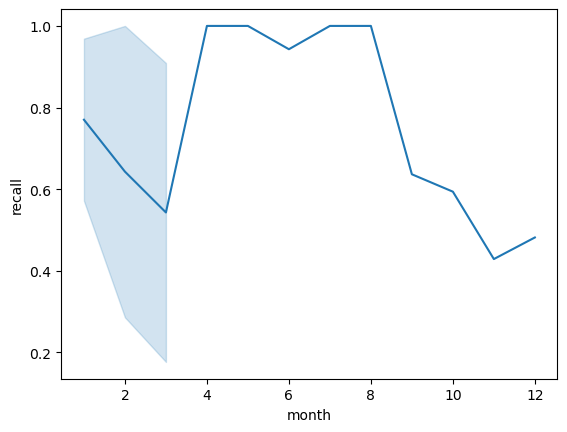

In [123]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [124]:
tes_corte_01['date_receiver'].dt.floor('d')

403        2023-01-19
1017       2023-06-04
1379       2023-04-29
2474       2023-05-21
2778       2023-04-07
              ...    
32963714   2024-03-27
32964465   2024-03-17
32964601   2024-03-22
32965756   2024-03-06
32967184   2024-03-09
Name: date_receiver, Length: 34864, dtype: datetime64[ns]

In [125]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
ALERTAS_01.to_csv ('./alertas.csv')

In [126]:
ALERTAS_01

targetF,False,True
date_receiver,,
2023-01-01,15,0
2023-01-02,51,0
2023-01-03,48,0
2023-01-04,59,11
2023-01-05,52,19
...,...,...
2024-03-26,38,0
2024-03-27,72,0
2024-03-28,33,0


In [127]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
#FRAUDES.to_csv ('./fraudes.csv')

In [128]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2024-03-27,52849,0
2024-03-28,48518,0
2024-03-29,65119,0


## Missing frauds

In [129]:
faltantes = (testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')
X_faltantes = testeo[faltantes]
Y_c_faltantes = Y_c[faltantes]
Y_c_faltantes[['pred_corte','pred_corte_01','pred_corte_02','pred_corte_03']].value_counts()

pred_corte  pred_corte_01  pred_corte_02  pred_corte_03
False       False          False          False            27
Name: count, dtype: int64

In [130]:
X_faltantes[var_input].describe()

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_var_range_hist,sender_days_to_last_transaction_more7m,receiver_transaction_count,01_sender_sending_days,branch_working_days,01_net_amount_receiver,sender_minutes_since_last_transaction_2days,sender_days_to_last_transaction_365,sender_days_to_last_transaction_7m,01_hour_receiver
count,27.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000,26.0000000000,27.0000000000,27.0000000000,26.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000,27.0000000000
mean,32.9259259259,"1,988.6296296296",0.0000000000,2.7407407407,1.4444444444,0.5555555556,0.0000000000,4.5925925926,0.0000000000,1.7654088748,0.0000000000,2.3703703704,0.2376450365,265.2222222222,0.3276464727,192.1111111111,11.5555555556,11.5555555556,0.8364197531
std,115.7217903574,5.9494547142,0.0000000000,1.6777409856,0.8473185457,0.5773502692,0.0000000000,3.3997653681,0.0000000000,1.7366871844,0.0000000000,4.0491988585,0.1405961640,0.4236592729,0.1109363081,677.0126878332,10.3824309193,10.3824309193,0.2152461837
min,1.0000000000,"1,979.0000000000",0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.5263157895,0.0000000000,1.0000000000,0.0013966480,265.0000000000,0.0731202609,0.0000000000,0.0000000000,0.0000000000,0.3750000000
25%,2.0000000000,"1,985.5000000000",0.0000000000,1.0000000000,1.0000000000,0.0000000000,0.0000000000,2.0000000000,0.0000000000,0.8134566327,0.0000000000,1.0000000000,0.0953212291,265.0000000000,0.2833410110,0.0000000000,2.5000000000,2.5000000000,0.9166666667
50%,4.0000000000,"1,988.0000000000",0.0000000000,4.0000000000,2.0000000000,1.0000000000,0.0000000000,3.0000000000,0.0000000000,1.2215909091,0.0000000000,1.0000000000,0.3086592179,265.0000000000,0.3363532001,0.0000000000,7.0000000000,7.0000000000,0.9583333333
75%,5.0000000000,"1,990.0000000000",0.0000000000,4.0000000000,2.0000000000,1.0000000000,0.0000000000,7.0000000000,0.0000000000,1.8763234747,0.0000000000,1.0000000000,0.3596368715,265.0000000000,0.3747413371,0.0000000000,22.0000000000,22.0000000000,0.9583333333
max,602.0000000000,"2,001.0000000000",0.0000000000,5.0000000000,3.0000000000,2.0000000000,0.0000000000,13.0000000000,0.0000000000,8.2526315789,0.0000000000,17.0000000000,0.3687150838,266.0000000000,0.5849620871,"2,866.0000000000",34.0000000000,34.0000000000,0.9583333333


In [131]:
#testeo.loc[(testeo['id_receiver'] ==5631) & (testeo['id_branch'] =='A24793')] 

testeo.loc[(testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')] 

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target,id_payout_G,year
30745840,A24793,5656,2024-03-22 10:11:13.040,TX1505,NN,10326891,900.0000000000,GUA,GUA6,TX,266,263.0000000000,33.0000000000,USA,None,"46,982.0000000000",10.0000000000,0.0000000000,"2,001.0000000000",TX,0,0,2,0,2,0,2.0000000000,800.0000000000,0,15.0000000000,3,10,False,True,1.1250000000,False,False,False,False,True,False,33.0000000000,0,33.0000000000,0,0.0000000000,0.0000000000,0.1473684211,0.3673184358,0.0471857095,0.3290411740,0.0000000000,0.0000000000,0.0904109589,0.1571428571,0.4166666667,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2024
30961307,A24793,5644,2024-03-21 23:55:40.800,TX1505,NN,10339243,"1,150.0000000000",MEX,MEX35,TX,265,259.0000000000,14.0000000000,USA,None,"20,943.0000000000",2.0000000000,0.0000000000,"1,988.0000000000",TX,0,0,4,2,1,0,2.0000000000,800.0000000000,0,1.0000000000,3,23,True,True,1.4375000000,False,False,False,False,False,True,14.0000000000,0,14.0000000000,0,0.0000000000,0.0000000000,0.0000000000,0.3617318436,0.0470171891,0.4204415001,0.0000000000,0.0000000000,0.0383561644,0.0666666667,0.9583333333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,2024
31213352,A24793,5640,2024-03-21 23:56:07.267,TX1505,NN,10345474,"1,450.0000000000",MEX,MEX16,TX,265,258.0000000000,6.0000000000,USA,None,"8,925.0000000000",1.0000000000,0.0000000000,"1,999.0000000000",TX,0,0,5,3,1,0,7.0000000000,"1,100.0000000000",0,1.0000000000,3,23,True,True,1.3181818182,False,False,False,False,True,False,6.0000000000,0,6.0000000000,0,0.0000000000,0.0000000000,0.0000000000,0.3603351955,0.0470171891,0.5301218915,0.0000000000,0.0000000000,0.0164383562,0.0285714286,0.9583333333,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2024
31253540,A24793,5653,2024-03-21 23:55:40.800,TX1505,NN,10398602,650.0000000000,MEX,MEX47,TX,265,184.0000000000,7.0000000000,USA,None,"10,558.0000000000",2.0000000000,0.0000000000,"1,988.0000000000",TX,0,0,4,2,1,0,2.0000000000,800.0000000000,0,1.0000000000,3,23,True,True,0.8125000000,False,False,False,False,False,True,7.0000000000,0,7.0000000000,0,0.0000000000,0.0000000000,0.0000000000,0.2569832402,0.0470171891,0.2376408479,0.0000000000,0.0000000000,0.0191780822,0.0333333333,0.9583333333,False,False,False,True,False,False,False,False,True,Fals

In [132]:
Y_c.loc[(testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')] 

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,FRAUD_DECILE,fraud_classification,targetF,pred_corte_01,pred_corte_02,pred_corte_03,pred_corte_04
30745840,False,False,False,False,True,False,False,False,False,0.0000000000,False,100,None,False,False,False,False,False
30961307,False,False,False,True,False,False,False,False,False,0.0000000001,False,22,None,False,False,False,False,False
31213352,False,False,False,True,False,False,False,False,False,0.0000000002,False,15,None,False,False,False,False,False
31253540,False,False,False,True,False,False,False,False,False,0.0000000002,False,13,None,False,False,False,False,False
31321486,False,False,False,True,False,False,False,False,False,0.0000000033,False,3,None,False,False,False,False,False
31380509,False,False,False,True,False,False,False,False,False,0.0000000002,False,13,None,False,False,False,False,False
31619975,False,False,False,True,False,False,False,False,False,0.0000000000,False,28,None,False,False,False,False,False
31639464,False,False,False,False,True,False,False,False,False,0.0000000000,False,77,None,False,False,False,False,False
31657291,False,False,False,False,True,False,False,False,False,0.0000000000,False,44,None,False,False,False,False,False
31740059,False,False,False,True,False,False,False,False,False,0.0000000002,False,15,None,False,False,False,False,False


In [133]:
Y_c.loc[(testeo['id_receiver'].between(1783,1783)) & (testeo['id_branch'] =='A20109'),'pred_corte_01'] 

31754334    True
Name: pred_corte_01, dtype: bool

In [144]:
testeo[(testeo['id_receiver'].between(1783,1783)) & (testeo['id_branch'] =='A20109')]

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target,id_payout_G,year
31754334,A20109,1783,2024-03-22 15:43:01.377,AR0206,NN,11581175,975.0000000000,MEX,MEX11,AR,1262,NaN,0.0000000000,USA,None,0.0000000000,102.0000000000,0.0000000000,155.0000000000,AR,0,0,0,0,0,0,0.0000000000,NaN,0,1.0000000000,3,15,True,True,NaN,False,False,False,False,False,True,0.0000000000,0,0.0000000000,0,0.0000000000,0.0000000000,0.0000000000,NaN,0.2150320189,0.3564612719,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.6250000000,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,2024


In [134]:
faltantes = (testeo['id_receiver'].between(174,178)) & (testeo['id_branch'] =='A25879')
X_faltantes = testeo[faltantes]
Y_c_faltantes = Y_c[faltantes]
Y_c_faltantes[['pred_corte','pred_corte_01','pred_corte_02','pred_corte_03']].value_counts()

Series([], Name: count, dtype: int64)

In [135]:
testeo[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883)]
testeo[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883)]

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target,id_payout_G,year
16726691,A24570,1883,2023-09-01 19:33:58.957,NY1438,T085,10617643,128.0000000000,GUA,GUA11,NY,57,NaN,0.0000000000,USA,None,0.0000000000,6.0000000000,0.0000000000,"1,806.0000000000",NY,0,0,7,2,7,0,0.0000000000,NaN,0,4.0000000000,9,19,False,True,NaN,False,False,False,False,True,False,0.0000000000,0,0.0000000000,0,0.0000000000,0.0000000000,0.0297029703,NaN,0.0256582257,0.0462093863,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.7916666667,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2023


In [136]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Faltantes.parquet")

testeo2 = tes
Y_target2 = pd.DataFrame(tes['target']) 

In [137]:
testeo2['01_var_range_hist'] = testeo.loc[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883),'01_var_range_hist']
testeo2['01_var_range_hist'] 

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
Name: 01_var_range_hist, dtype: float64

In [138]:
testeo2[var_input]

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,receiver_transaction_count,01_sender_sending_days,branch_working_days,01_net_amount_receiver,sender_minutes_since_last_transaction_2days,sender_days_to_last_transaction_365,sender_days_to_last_transaction_7m,01_hour_receiver
0,6,1975,0,1,1,1,0,0,0,True,False,NaN,False,False,False,True,0,1,0,265,1.0000000000,0,0,0,0.8333333333
1,15,1974,0,2,0,1,0,0,0,True,True,NaN,False,False,False,True,0,1,0,265,0.6946424785,0,0,0,0.8333333333
2,7,1977,0,4,0,3,0,0,0,True,True,NaN,False,False,False,True,0,1,0,265,1.0000000000,0,0,0,0.8750000000
3,12,169,0,1,0,0,0,0,0,True,False,NaN,False,False,False,True,0,1,0,79,0.1828006522,0,0,0,0.5000000000
4,2833,168,0,0,0,0,0,0,0,True,True,NaN,False,False,False,True,0,1,0,79,0.3473212392,0,0,0,0.5000000000
5,11,170,0,2,0,0,0,0,0,True,True,NaN,False,False,False,True,0,1,0,79,0.3582892784,0,0,0,0.5000000000
6,20,171,0,2,0,0,0,0,0,True,True,NaN,False,False,False,True,0,1,0,79,0.4679696697,0,0,0,0.5416666667


In [139]:
testeo_data_pred_rf2 = modelo.predict(testeo2[var_input])
probab_rf2 = modelo.predict_proba(testeo2[var_input])
score_rf2 = np.delete(probab_rf2, np.s_[0], axis=1)

Y_c2 = Y_target2.copy()
Y_c2['preds_rf'] = testeo_data_pred_rf2
Y_c2['score_rf'] = score_rf2


In [140]:
Y_c2

,target,preds_rf,score_rf
0,True,False,0.0000000029
1,True,False,0.0000000042
2,True,False,0.0000000001
3,False,False,0.0000000018
4,False,False,0.0000000026
5,False,False,0.0000000013
6,False,False,0.0000000072


In [141]:
Y_c2['pred_corte_01'] = Y_c2['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c2['target'], Y_c2['pred_corte_01']))

,0,1
0,4,0
1,3,0


In [142]:
Y_c2['pred_corte_02'] = Y_c2['score_rf']>corte_02
pd.DataFrame(confusion_matrix(Y_c2['target'], Y_c2['pred_corte_02']))

,0,1
0,4,0
1,3,0


In [143]:
Y_c2['pred_corte'] = Y_c2['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c2['target'], Y_c2['pred_corte']))

,0,1
0,4,0
1,3,0
